In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV, calibration_curve, CalibrationDisplay
from sklearn.frozen import FrozenEstimator
from sklearn.model_selection import train_test_split
import pickle
import lightning
from chemprop import nn, data, featurizers
from pathlib import Path
import pandas as pd
import numpy as np
from ergochemics.mapping import rc_to_nest
from torch.utils.data import DataLoader
from hydra import initialize, compose
from hydra.utils import instantiate
from cgr.ml import (
    GNN,
    FFNPredictor,
    LinearPredictor,
    collate_batch,
    sep_aidx_to_bin_label,
    calc_bce_pos_weight,
    SklearnGNN
)

In [3]:
with initialize(version_base=None, config_path="../configs"):
    cfg = compose(config_name="train")

In [4]:
X, y = make_classification(n_samples=5_000, n_features=2,
                           n_redundant=0, random_state=42)
X_train_calib, X_test, y_train_calib, y_test = train_test_split(
       X, y, random_state=42
)
X_train, X_calib, y_train, y_calib = train_test_split(
       X_train_calib, y_train_calib, random_state=42
)

In [5]:
base_clf = GaussianNB()
base_clf.fit(X_train, y_train)
calibrated_clf = CalibratedClassifierCV(FrozenEstimator(base_clf))
calibrated_clf.fit(X_calib, y_calib)
len(calibrated_clf.calibrated_classifiers_)
calibrated_clf.predict_proba([[-0.5, 0.5]])

array([[0.80944913, 0.19055087]])

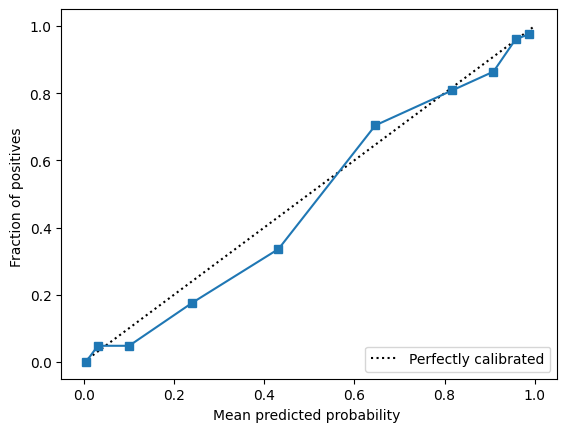

In [6]:
y_prob = base_clf.predict_proba(X_test)[:, 1]
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy="quantile")
disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
disp.plot()

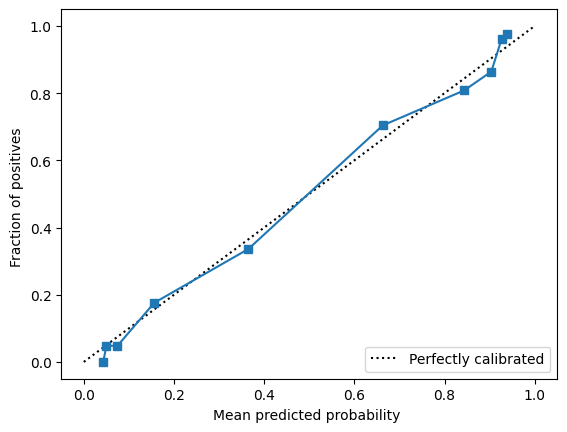

In [7]:
y_prob = calibrated_clf.predict_proba(X_test)[:, 1]
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy="quantile")
disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
disp.plot()

In [8]:

df = pd.read_parquet(
        Path(cfg.mechinformed_mapped_rxns)
)[:1000]

# Prep data
df["template_aidxs"] = df["template_aidxs"].apply(rc_to_nest)
smis = df["am_smarts"].tolist()
df["binary_label"] = df.apply(lambda x: sep_aidx_to_bin_label(x.am_smarts, x.template_aidxs), axis=1) # Convert aidxs to binary labels for block mol
ys = [elt[0] for elt in df["binary_label"]]
groups = df["rule_id"].tolist() if cfg.data.split_strategy != "random_split" else None
X, y = zip(*[(data.ReactionDatapoint.from_smi(smi), y) for smi, y in zip(smis, ys)])

# Split
outer_splitter = instantiate(cfg.data.outer_splitter)
train_val_idx, test_idx = list(outer_splitter.split(X, y, groups=groups))[cfg.data.outer_split_idx]
train_X, train_y = [X[i] for i in train_val_idx], [y[i] for i in train_val_idx]
test_X, test_y = [X[i] for i in test_idx], [y[i] for i in test_idx]
test_rxn_ids = [df.iloc[i]["rxn_id"] for i in test_idx]

# Featurize
featurizer = featurizers.CondensedGraphOfReactionFeaturizer(mode_=cfg.model.featurizer_mode, atom_featurizer=featurizers.MultiHotAtomFeaturizer.v2())
train_dataset = list(zip(data.ReactionDataset(train_X, featurizer=featurizer), train_y))
test_dataset = list(zip(data.ReactionDataset(test_X, featurizer=featurizer), test_y))
train_dataloader = DataLoader(train_dataset, batch_size=cfg.training.batch_size, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_batch)

# Construct model
mp = nn.BondMessagePassing(d_v=featurizer.atom_fdim, d_e=featurizer.bond_fdim, d_h=cfg.model.mp_d_h, depth=cfg.model.mp_depth)
if cfg.model.pred_head_name == 'linear':
    pred_head = LinearPredictor(input_dim=cfg.model.mp_d_h, output_dim=1)
elif cfg.model.pred_head_name == 'ffn':
    pred_head = FFNPredictor(input_dim=cfg.model.mp_d_h, output_dim=1, d_hs=cfg.model.pred_head_d_hs)

model = GNN(
    message_passing=mp,
    predictor=pred_head,
    pos_weight=calc_bce_pos_weight(train_y, cfg.training.pw_scl),
    warmup_epochs=cfg.training.warmup_epochs,
    init_lr=cfg.training.init_lr,
    max_lr=cfg.training.max_lr,
    final_lr=cfg.training.final_lr,
)

trainer = lightning.Trainer(logger=None, accelerator="auto", devices=1)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/stef/cgr/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [9]:
skgnn = SklearnGNN(model=model, message_passing=mp, predictor=pred_head, trainer=trainer)

In [10]:
expanded_test_dataset = []
for i, (x, y) in enumerate(test_dataset):
    for j in range(y.shape[0]):
        expanded_test_dataset.append((x, i))

In [11]:
skgnn.predict_proba(expanded_test_dataset[:154])

/home/stef/cgr/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

array([[0.49792928, 0.5020707 ],
       [0.48661792, 0.5133821 ],
       [0.4966746 , 0.5033254 ],
       [0.49170315, 0.50829685],
       [0.5028187 , 0.4971813 ],
       [0.4937067 , 0.5062933 ],
       [0.49156708, 0.5084329 ],
       [0.50324905, 0.49675092],
       [0.5101177 , 0.4898823 ],
       [0.49451852, 0.5054815 ],
       [0.4954909 , 0.5045091 ],
       [0.48466468, 0.5153353 ],
       [0.50263083, 0.4973692 ],
       [0.5050159 , 0.4949841 ],
       [0.522306  , 0.47769397],
       [0.5108274 , 0.48917258],
       [0.5121695 , 0.4878305 ],
       [0.51428837, 0.48571163],
       [0.5169295 , 0.4830705 ],
       [0.5072572 , 0.49274275],
       [0.51781714, 0.48218283],
       [0.5099664 , 0.49003366],
       [0.5131017 , 0.48689833],
       [0.49254245, 0.50745755],
       [0.5052819 , 0.49471807],
       [0.49085647, 0.50914353],
       [0.50518644, 0.49481356],
       [0.49792928, 0.5020707 ],
       [0.48661792, 0.5133821 ],
       [0.4966746 , 0.5033254 ],
       [0.

In [12]:
with open("../scripts/calibrated_skgnn.pkl", "rb") as f:
    calibrated_skgnn = pickle.load(f)

In [13]:
calibrated_skgnn

CalibratedClassifierCV(estimator=FrozenEstimator(estimator=SklearnGNN(message_passing=BondMessagePassing(
  (W_i): Linear(in_features=134, out_features=300, bias=False)
  (W_h): Linear(in_features=300, out_features=300, bias=False)
  (W_o): Linear(in_features=406, out_features=300, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (tau): ReLU()
  (V_d_transform): Identity(...
    (W_h): Linear(in_features=300, out_features=300, bias=False)
    (W_o): Linear(in_features=406, out_features=300, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (tau): ReLU()
    (V_d_transform): Identity()
    (graph_transform): Identity()
  )
),
                                                                      predictor=LinearPredictor(
  (linear): Linear(in_features=300, out_features=1, bias=True)
),
                                                                      trainer=<lightning.pytorch.trainer.trainer.Trainer object at 0x7367d26779d0>)))

In [14]:
calibrated_skgnn.predict_proba(expanded_test_dataset[:154])

/home/stef/cgr/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

array([[0.92852597, 0.07147403],
       [0.93100708, 0.06899292],
       [0.93468365, 0.06531635],
       [0.9263138 , 0.0736862 ],
       [0.92538543, 0.07461457],
       [0.92312859, 0.07687141],
       [0.92930196, 0.07069804],
       [0.92761748, 0.07238252],
       [0.9299835 , 0.0700165 ],
       [0.93256419, 0.06743581],
       [0.92977856, 0.07022144],
       [0.93031189, 0.06968811],
       [0.92883114, 0.07116886],
       [0.92719642, 0.07280358],
       [0.92698799, 0.07301201],
       [0.92343761, 0.07656239],
       [0.92632387, 0.07367613],
       [0.92468999, 0.07531001],
       [0.92745581, 0.07254419],
       [0.92454248, 0.07545752],
       [0.92606106, 0.07393894],
       [0.92309359, 0.07690641],
       [0.92521656, 0.07478344],
       [0.92867201, 0.07132799],
       [0.92758032, 0.07241968],
       [0.92919092, 0.07080908],
       [0.92762274, 0.07237726],
       [0.92852597, 0.07147403],
       [0.93100708, 0.06899292],
       [0.93468365, 0.06531635],
       [0.